In [1]:
# These scripts are used to parse my data into

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import os

target_dir = "Bike 07-06-23 8:52"
target_dir2 = "Bike 07-06-23 14:27"

In [2]:
from statistics import mean

def time_diff(df):
    res = []
    for i in range(len(df["Time (s)"]) - 1):
        val1 = df["Time (s)"][i]
        val2 = df["Time (s)"][i + 1]
        
        res.append(val2 - val1)
    return mean(res)

def read_phyphox(parent_dir):
    acc = pd.read_csv(os.path.join(parent_dir, "Phyphox", "Accelerometer.csv"))
    gyro = pd.read_csv(os.path.join(parent_dir, "Phyphox", "Gyroscope.csv"))
    loc = pd.read_csv(os.path.join(parent_dir, "Phyphox", "Location.csv"))
        
    data_len = min(len(acc), len(gyro))
    acc = acc[0:data_len]
    gyro = gyro[0:data_len]
        
    time_step = mean([time_diff(acc), time_diff(gyro)])
    
    for i in range(data_len):
        time = time_step * i
        acc["Time (s)"][i] = time
        gyro["Time (s)"][i] = time
    
    acc.set_index('Time (s)', inplace=True)
    gyro.set_index('Time (s)', inplace=True)
    loc.set_index('Time (s)', inplace=True)
        
            
    merged = acc.join(gyro, how="outer")
    merged = pd.concat([merged, loc]).sort_index().interpolate()
    
    # Rename columns
    merged.index.names = ["time"]
    merged.rename(inplace=True, columns={
        "Acceleration x (m/s^2)": "acceleration_x",
        "Acceleration y (m/s^2)": "acceleration_y",
        "Acceleration z (m/s^2)": "acceleration_z",
        "Gyroscope x (rad/s)": "gyroscope_x",
        "Gyroscope y (rad/s)": "gyroscope_y",
        "Gyroscope z (rad/s)": "gyroscope_z",
        "Latitude (°)": "latitude",
        "Longitude (°)": "longitude",
        "Height (m)": "height",
        "Velocity (m/s)": "velocity",
        "Direction (°)": "direction",
        "Horizontal Accuracy (m)": "h_accuracy",
        "Vertical Accuracy (m)": "v_accuracy",

    })
    merged = merged.dropna()
    
    time_df = pd.read_csv(os.path.join(parent_dir, "Phyphox", "meta", "time.csv"))
    start_time = time_df.loc[time_df["event"] == "START"]["system time"][0]
    
    merged.reset_index(inplace=True)
    merged['time'] = pd.to_datetime(merged['time'] + start_time, unit='s')
    return merged

read_phyphox(target_dir)

,time,acceleration_x,acceleration_y,acceleration_z,gyroscope_x,gyroscope_y,gyroscope_z,latitude,longitude,height,velocity,direction,h_accuracy,v_accuracy
0,2023-06-07 06:22:51.237444878,1.479975,4.688025,8.505450,-0.083256,-0.035956,-0.047644,52.278535,4.824785,-67.529845,0.758701,64.440002,9.10,91.699997
1,2023-06-07 06:22:51.357940912,0.751950,3.868050,9.076950,-0.041250,-0.046475,-0.062150,52.278468,4.824891,-69.529879,0.701824,58.365002,7.05,89.599998
2,2023-06-07 06:22:51.751848936,1.387300,4.062050,8.925950,-0.119212,0.199558,-0.065450,52.278402,4.824997,-71.529913,0.644947,52.290001,5.00,87.500000
3,2023-06-07 06:22:52.240046024,2.022650,4.256050,8.774950,-0.197175,0.445592,-0.068750,52.278388,4.825015,-74.229921,1.020694,24.639999,3.50,85.500000
4,2023-06-07 06:22:52.357411385,2.658000,4.450050,8.623950,-0.275137,0.691625,-0.072050,52.278392,4.825022,-74.629912,0.946574,24.105000,3.40,82.450001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3568,2023-06-07 06:52:37.411697626,6.423000,-10.324051,1.669050,0.150287,-0.078237,-0.280775,52.334605,4.864740,-33.228580,2.067639,134.669998,5.90,13.000000
3569,2023-06-07 06:52:38.411168098,13.989000,-12.897000,-1.638000,1.387787,3.768462,-3.214887,52.334605,4.864740,-33.228580,2.067639,134.669998,5.90,13.000000
3570,2023-06-07 06:52:39.410638571,0.193950,3.823950,9.574950,-0.194150,0.261525,-0.985875,52.334605,4.864740,-33.228580,2.067639,134.669998,5.90,13.000000
3571,2023-06-07 06:52:40.410109043,0.586050,4.098000,7.506001,-0.145200,0.679525,0.005225,52.334605,4.864740,-33.228580,2.067639,134.669998,5.90,13.000000


In [3]:
def read_samsung_health(parent_dir):
    files = os.scandir(os.path.join(parent_dir, "SamsungHealth"))
    filename = next(filter(lambda file: "com.samsung.health.exercise.live_data.json" in file.name, files)).name
        
    df = pd.read_json(os.path.join(parent_dir, "SamsungHealth", filename))
    df = df[["start_time", "heart_rate"]].dropna()

    return df

read_samsung_health(target_dir)

,start_time,heart_rate
1,2023-06-07 06:22:31.971,97.0
3,2023-06-07 06:22:41.550,90.0
5,2023-06-07 06:22:43.547,89.0
6,2023-06-07 06:22:51.541,100.0
8,2023-06-07 06:23:01.628,101.0
...,...,...
419,2023-06-07 06:52:32.054,154.0
420,2023-06-07 06:52:42.056,153.0
421,2023-06-07 06:52:52.057,157.0
422,2023-06-07 06:53:01.531,154.0


In [4]:
def read_combined(parent_dir):
    pp = read_phyphox(parent_dir)
    sh = read_samsung_health(parent_dir)
    
    pp["heart_rate"] = np.nan
    
    
    # Finds the time intervals of the heart rate measurements and update the phyphox heart rate accordingly
    # This is done as samsung measurements are not very fine grained and only give use relatively large
    # time intervals
    for i in range(len(sh) - 1):
        row1 = sh.iloc[i]
        row2 = sh.iloc[i + 1]
        pp.loc[(pp["time"] >= row1["start_time"]) & (pp["time"] < row2["start_time"]), "heart_rate"] = row1["heart_rate"]
    
    return pp.dropna()

read_combined(target_dir2)

,time,acceleration_x,acceleration_y,acceleration_z,gyroscope_x,gyroscope_y,gyroscope_z,latitude,longitude,height,velocity,direction,h_accuracy,v_accuracy,heart_rate
0,2023-06-07 11:56:22.357122660,1.551000,4.879500,8.588551,-0.002406,0.278644,0.136813,52.335309,4.864779,0.772433,0.000000,0.000000,56.099998,8.217778,96.0
1,2023-06-07 11:56:22.427900553,0.969000,4.608000,8.962050,0.100100,0.096112,0.175863,52.335226,4.864760,0.647304,0.255560,50.595001,44.199999,9.563334,96.0
2,2023-06-07 11:56:22.677867651,0.651000,4.396950,8.713051,-0.044825,0.074112,0.055825,52.335142,4.864740,0.522175,0.511119,101.190002,32.299999,10.908889,96.0
3,2023-06-07 11:56:22.927834511,0.694050,4.236000,9.060000,-0.040838,0.071088,0.033825,52.335059,4.864721,0.397047,0.766679,151.785004,20.400000,12.254445,96.0
4,2023-06-07 11:56:23.049318075,0.620025,4.191975,9.090001,-0.037331,0.059606,0.022344,52.334975,4.864702,0.271918,1.022238,202.380005,8.500000,13.600000,96.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7508,2023-06-07 12:21:23.229163408,-1.780950,-9.523951,-2.586000,1.098350,-0.448388,-0.719262,52.278317,4.825148,-53.089947,0.000000,293.380005,2.000000,6.920000,151.0
7509,2023-06-07 12:21:23.479130268,1.044000,-9.225000,1.839000,0.159362,0.112613,0.077688,52.278317,4.825149,-53.069946,0.000000,293.380005,2.000000,7.080000,151.0
7510,2023-06-07 12:21:23.729097128,-1.207050,-9.472051,-1.357050,0.081400,-0.102437,-0.004262,52.278317,4.825149,-53.049946,0.000000,293.380005,2.000000,7.240000,151.0
7511,2023-06-07 12:21:23.875818014,-0.524025,-9.304050,-0.554025,0.733425,-0.715412,-0.340313,52.278317,4.825150,-53.029946,0.000000,293.380005,2.000000,7.400000,151.0


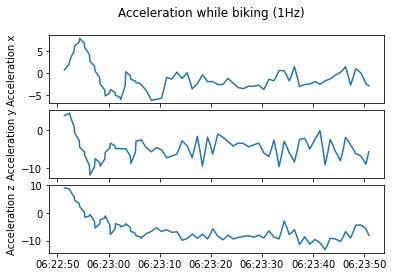

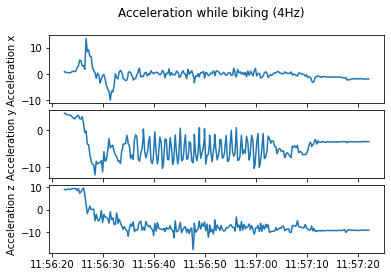

In [5]:
# Plot 60 seconds of accelerometer data for 1 and 4 hz
interval = 60

df_1hz = read_combined(target_dir)
begin_timestamp = df_1hz["time"][0].timestamp()
df_1hz = df_1hz[(df_1hz["time"] >= pd.to_datetime(begin_timestamp, unit='s')) & (df_1hz["time"] < pd.to_datetime(begin_timestamp + interval, unit='s'))]

df_4hz = read_combined(target_dir2)
begin_timestamp = df_4hz["time"][0].timestamp()
df_4hz = df_4hz[(df_4hz["time"] >= pd.to_datetime(begin_timestamp, unit='s')) & (df_4hz["time"] < pd.to_datetime(begin_timestamp + interval, unit='s'))]

fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True)

fig.suptitle("Acceleration while biking (1Hz)")

ax1.plot(df_1hz["time"], df_1hz["acceleration_x"])
ax1.set_ylabel("Acceleration x")

ax2.plot(df_1hz["time"], df_1hz["acceleration_y"])
ax2.set_ylabel("Acceleration y")

ax3.plot(df_1hz["time"], df_1hz["acceleration_z"])
ax3.set_ylabel("Acceleration z")

plt.subplots_adjust(hspace=0.1)
fig.align_labels()

plt.savefig("biking_acceleration_1hz.pdf", format="pdf", bbox_inches="tight")

fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True)

fig.suptitle("Acceleration while biking (4Hz)")

ax1.plot(df_4hz["time"], df_4hz["acceleration_x"])
ax1.set_ylabel("Acceleration x")

ax2.plot(df_4hz["time"], df_4hz["acceleration_y"])
ax2.set_ylabel("Acceleration y")

ax3.plot(df_4hz["time"], df_4hz["acceleration_z"])
ax3.set_ylabel("Acceleration z")

plt.subplots_adjust(hspace=0.1)
fig.align_labels()

plt.savefig("biking_acceleration_4hz.pdf", format="pdf", bbox_inches="tight")

Exception in Tkinter callback
Traceback (most recent call last):
  File "/home/alessandrobalducci/.conda/envs/myenv/lib/python3.8/tkinter/__init__.py", line 1892, in __call__
    return self.func(*args)
  File "/home/alessandrobalducci/.conda/envs/myenv/lib/python3.8/tkinter/__init__.py", line 814, in callit
    func(*args)
  File "/home/alessandrobalducci/.conda/envs/myenv/lib/python3.8/site-packages/matplotlib/backends/_backend_tk.py", line 270, in idle_draw
    self.draw()
  File "/home/alessandrobalducci/.conda/envs/myenv/lib/python3.8/site-packages/matplotlib/backends/backend_tkagg.py", line 9, in draw
    super(FigureCanvasTkAgg, self).draw()
  File "/home/alessandrobalducci/.conda/envs/myenv/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py", line 393, in draw
    self.figure.draw(self.renderer)
  File "/home/alessandrobalducci/.conda/envs/myenv/lib/python3.8/site-packages/matplotlib/backend_bases.py", line 1535, in _draw
    def _draw(renderer): raise Done(renderer

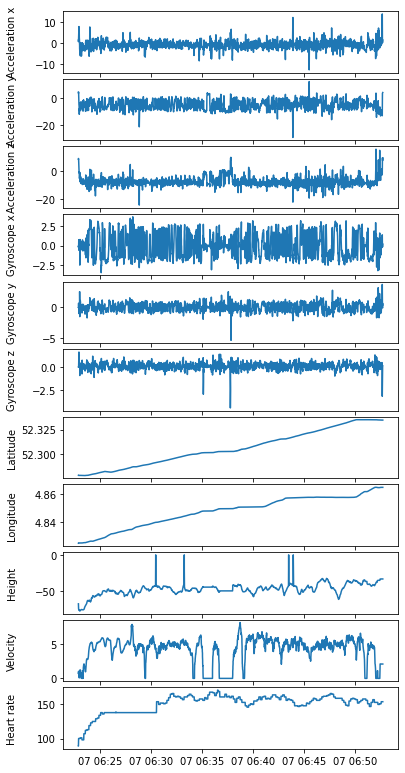

In [15]:
target_tram = "Tram 08-06-23 11:05"
target_walk = "Walk 08-06-23 10:41"

df = read_combined(target_dir)

def plot_outliers(ax, df, col):
    ax.plot(df.loc[df[col + "_outlier"] == True, "time"], df.loc[df[col + "_outlier"] == True, col], "rx")

def full_plot(df, show_outliers=False, filename=None):
    fig, axes = plt.subplots(11, sharex=True, figsize=(6, 15))

    axes[0].plot(df["time"], df["acceleration_x"])
    if show_outliers:
        plot_outliers(axes[0], df, "acceleration_x")
    axes[0].set_ylabel("Acceleration x")

    axes[1].plot(df["time"], df["acceleration_y"])
    if show_outliers:
        plot_outliers(axes[1], df, "acceleration_y")
    axes[1].set_ylabel("Acceleration y")

    axes[2].plot(df["time"], df["acceleration_z"])
    if show_outliers:
        plot_outliers(axes[2], df, "acceleration_z")
    axes[2].set_ylabel("Acceleration z")

    axes[3].plot(df["time"], df["gyroscope_x"])
    if show_outliers:
        plot_outliers(axes[3], df, "gyroscope_x")
    axes[3].set_ylabel("Gyroscope x")

    axes[4].plot(df["time"], df["gyroscope_y"])
    if show_outliers:
        plot_outliers(axes[4], df, "gyroscope_y")
    axes[4].set_ylabel("Gyroscope y")

    axes[5].plot(df["time"], df["gyroscope_z"])
    if show_outliers:
        plot_outliers(axes[5], df, "gyroscope_z")
    axes[5].set_ylabel("Gyroscope z")

    axes[6].plot(df["time"], df["latitude"])
    if show_outliers:
        plot_outliers(axes[6], df, "latitude")
    axes[6].set_ylabel("Latitude")

    axes[7].plot(df["time"], df["longitude"])
    if show_outliers:
        plot_outliers(axes[7], df, "longitude")
    axes[7].set_ylabel("Longitude")

    axes[8].plot(df["time"], df["height"])
    if show_outliers:
        plot_outliers(axes[8], df, "height")
    axes[8].set_ylabel("Height")

    axes[9].plot(df["time"], df["velocity"])
    if show_outliers:
        plot_outliers(axes[9], df, "velocity")
    axes[9].set_ylabel("Velocity")

    axes[10].plot(df["time"], df["heart_rate"])
    if show_outliers:
        plot_outliers(axes[10], df, "heart_rate")
    axes[10].set_ylabel("Heart rate")


    plt.subplots_adjust(hspace=0.1)
    fig.align_labels()
    
    if filename is not None:
        plt.savefig(filename, format="pdf", bbox_inches="tight")


full_plot(df)

In [7]:
import Python3Code.Chapter3.OutlierDetection as od

def set_outliers(df, outliers, col):
    df[col + "_outlier"] = False
    df.loc[out.index, col + "_outlier"] = True
    
distribution_od = od.DistributionBasedOutlierDetection()
distance_od = od.DistanceBasedOutlierDetection()
cols = ["acceleration_x", "acceleration_y", "acceleration_z", "gyroscope_x", "gyroscope_y", "gyroscope_z", "latitude", "longitude", "height", "velocity", "heart_rate"]

df = read_combined(target_dir2)
df

,time,acceleration_x,acceleration_y,acceleration_z,gyroscope_x,gyroscope_y,gyroscope_z,latitude,longitude,height,velocity,direction,h_accuracy,v_accuracy,heart_rate
0,2023-06-07 11:56:22.357122660,1.551000,4.879500,8.588551,-0.002406,0.278644,0.136813,52.335309,4.864779,0.772433,0.000000,0.000000,56.099998,8.217778,96.0
1,2023-06-07 11:56:22.427900553,0.969000,4.608000,8.962050,0.100100,0.096112,0.175863,52.335226,4.864760,0.647304,0.255560,50.595001,44.199999,9.563334,96.0
2,2023-06-07 11:56:22.677867651,0.651000,4.396950,8.713051,-0.044825,0.074112,0.055825,52.335142,4.864740,0.522175,0.511119,101.190002,32.299999,10.908889,96.0
3,2023-06-07 11:56:22.927834511,0.694050,4.236000,9.060000,-0.040838,0.071088,0.033825,52.335059,4.864721,0.397047,0.766679,151.785004,20.400000,12.254445,96.0
4,2023-06-07 11:56:23.049318075,0.620025,4.191975,9.090001,-0.037331,0.059606,0.022344,52.334975,4.864702,0.271918,1.022238,202.380005,8.500000,13.600000,96.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7508,2023-06-07 12:21:23.229163408,-1.780950,-9.523951,-2.586000,1.098350,-0.448388,-0.719262,52.278317,4.825148,-53.089947,0.000000,293.380005,2.000000,6.920000,151.0
7509,2023-06-07 12:21:23.479130268,1.044000,-9.225000,1.839000,0.159362,0.112613,0.077688,52.278317,4.825149,-53.069946,0.000000,293.380005,2.000000,7.080000,151.0
7510,2023-06-07 12:21:23.729097128,-1.207050,-9.472051,-1.357050,0.081400,-0.102437,-0.004262,52.278317,4.825149,-53.049946,0.000000,293.380005,2.000000,7.240000,151.0
7511,2023-06-07 12:21:23.875818014,-0.524025,-9.304050,-0.554025,0.733425,-0.715412,-0.340313,52.278317,4.825150,-53.029946,0.000000,293.380005,2.000000,7.400000,151.0


Num outliers: 255


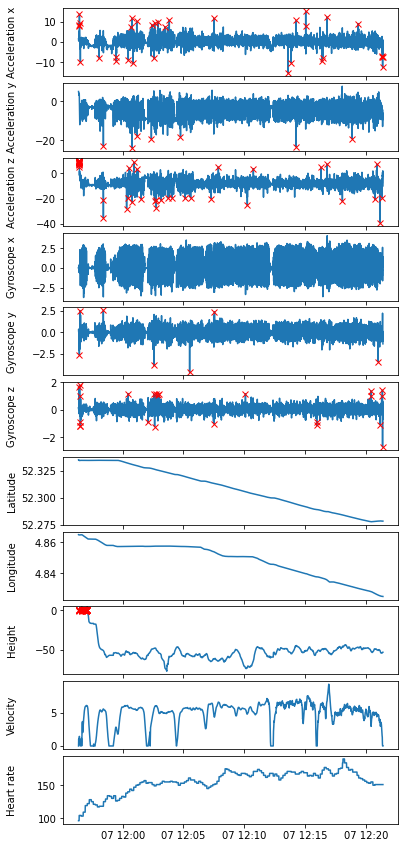

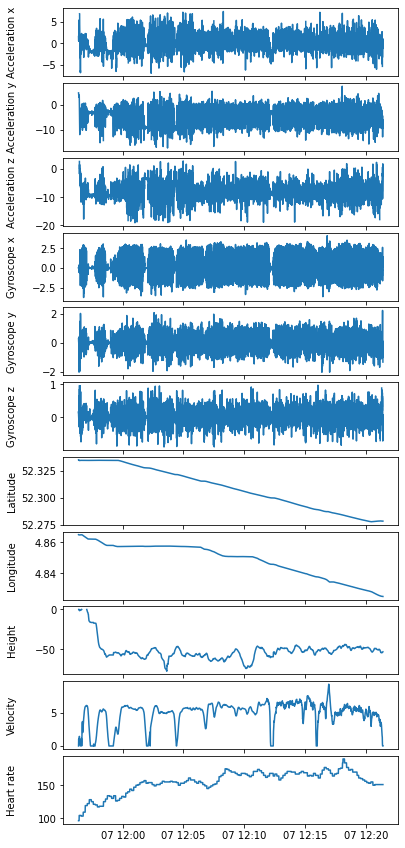

In [8]:
# Chauvenet

df_orig = df.copy()
df_clean = df.copy()
n_outliers = 0

for col in cols:
    df_orig[col + "_outlier"] = False
    df_orig = distribution_od.chauvenet(df_orig, col, 2)
    n_outliers += len(df_orig.loc[df_orig[col + "_outlier"] == True])
    
    df_clean.loc[df_orig[col + "_outlier"] == True, col] = np.nan
    
print(f"Num outliers: {n_outliers}")
full_plot(df_orig, show_outliers=True, filename="chauvenet_original.pdf")
full_plot(df_clean, filename="chauvenet_clean.pdf")

Num outliers: 789


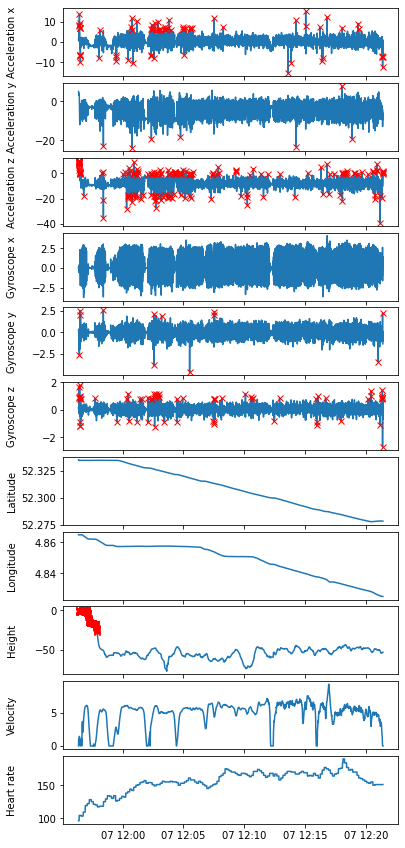

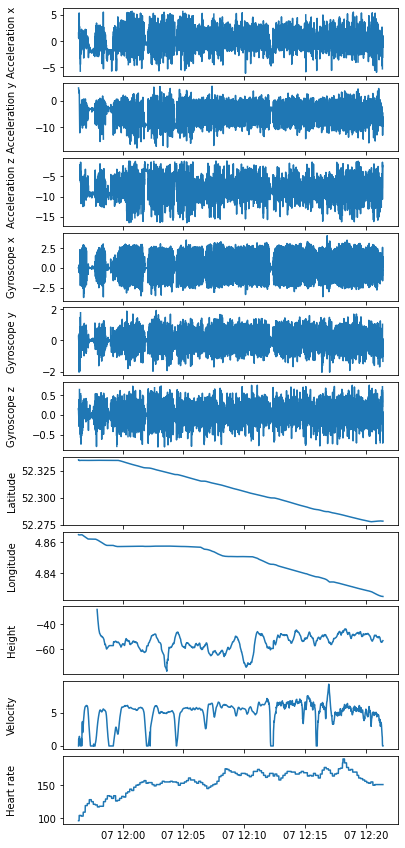

In [9]:
# Quantiles
import vutil

df_orig = df.copy()
df_clean = df.copy()
n_outliers = 0

for col in cols:
    df_orig[col + "_outlier"] = False
    out = vutil.find_outliers(df_orig, col)
    set_outliers(df_orig, out, col)
    n_outliers += len(df_orig.loc[df_orig[col + "_outlier"] == True])
    
    df_clean.loc[df_orig[col + "_outlier"] == True, col] = np.nan
    
print(f"Num outliers: {n_outliers}")
full_plot(df_orig, show_outliers=True, filename="quantiles_original.pdf")
full_plot(df_clean, filename="quantiles_clean.pdf")

Applying mixture models
Applying mixture models
Applying mixture models
Applying mixture models
Applying mixture models
Applying mixture models
Applying mixture models
Applying mixture models
Applying mixture models
Applying mixture models
Applying mixture models
Num outliers: 1114


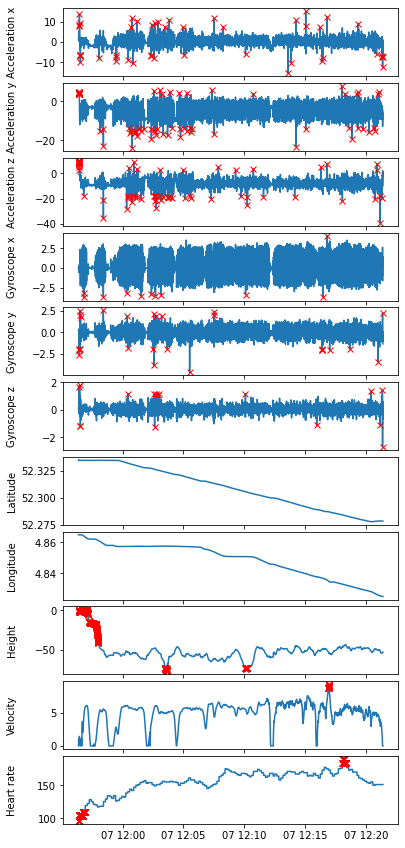

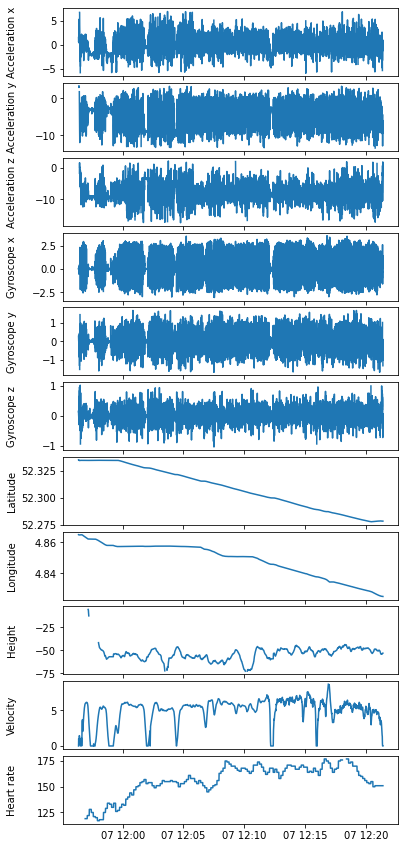

In [10]:
# Mixture

df_orig = df.copy()
df_clean = df.copy()
n_outliers = 0

for col in cols:
    df_orig[col + "_outlier"] = False
    df_orig = distribution_od.mixture_model(df_orig, col)
    df_orig.loc[df_orig[col + "_mixture"] < 0.000001, col + "_outlier"] = True

    n_outliers += len(df_orig.loc[df_orig[col + "_outlier"] == True])
    
    df_clean.loc[df_orig[col + "_outlier"] == True, col] = np.nan
    
print(f"Num outliers: {n_outliers}")
full_plot(df_orig, show_outliers=True, filename="mixture_original.pdf")
full_plot(df_clean, filename="mixture_clean.pdf")

Calculating simple distance-based criterion.
4
Calculating simple distance-based criterion.
20
Calculating simple distance-based criterion.
25
Calculating simple distance-based criterion.
1261
Calculating simple distance-based criterion.
1264
Calculating simple distance-based criterion.
1265
Calculating simple distance-based criterion.
6254
Calculating simple distance-based criterion.
11174
Calculating simple distance-based criterion.
15101
Calculating simple distance-based criterion.
16527
Calculating simple distance-based criterion.
20341
Num outliers: 20341


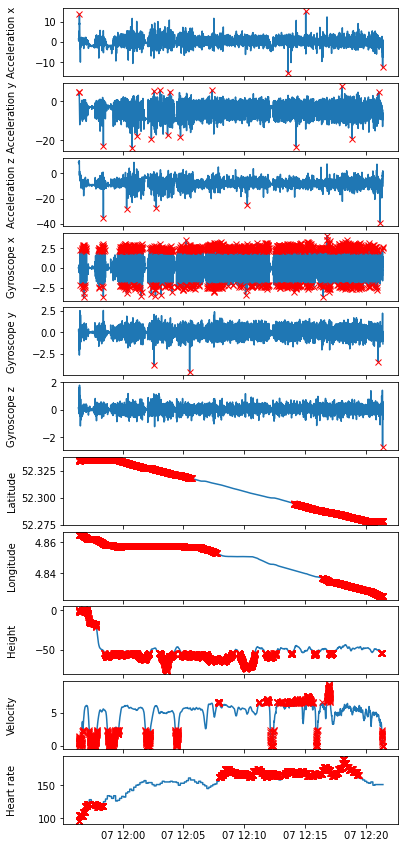

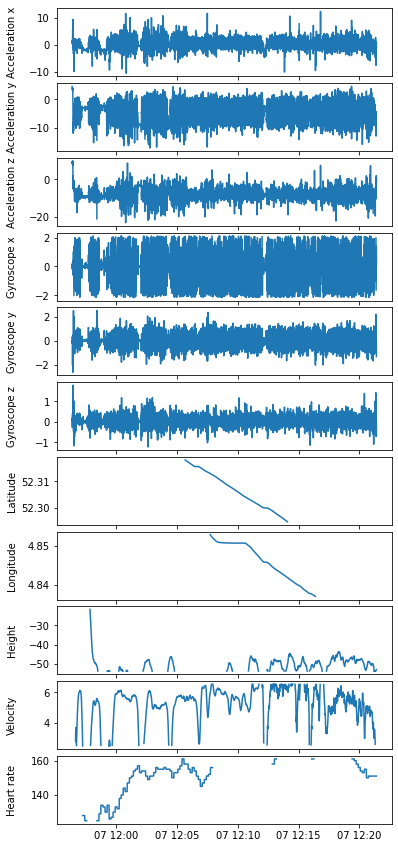

In [11]:
# Simple distance based

df_orig = df.copy()
df_clean = df.copy()
n_outliers = 0


for col in cols:
    df_orig = distance_od.simple_distance_based(df_orig, [col], "euclidean", 0.7, 1/1000)
    df_orig[col + "_outlier"] = df_orig["simple_dist_outlier"]
    
    n_outliers += len(df_orig.loc[df_orig[col + "_outlier"] == True])
    print(n_outliers)
    
    df_clean.loc[df_orig[col + "_outlier"] == True, col] = np.nan
    
print(f"Num outliers: {n_outliers}")
full_plot(df_orig, show_outliers=True, filename="simple_distance_original.pdf")
full_plot(df_clean, filename="simple_distance_clean.pdf")

In [12]:
# Calculate Local outlier factor
# Might take some time

df[col + "_outlier"] = False

df = distance_od.local_outlier_factor(df, ["acceleration_x"], "euclidean", 2)
df

Calculating local outlier factor.
Completed 0 steps for LOF.
Completed 100 steps for LOF.
Completed 200 steps for LOF.
Completed 300 steps for LOF.
Completed 400 steps for LOF.
Completed 500 steps for LOF.
Completed 600 steps for LOF.
Completed 700 steps for LOF.
Completed 800 steps for LOF.
Completed 900 steps for LOF.
Completed 1000 steps for LOF.
Completed 1100 steps for LOF.
Completed 1200 steps for LOF.
Completed 1300 steps for LOF.
Completed 1400 steps for LOF.
Completed 1500 steps for LOF.
Completed 1600 steps for LOF.
Completed 1700 steps for LOF.
Completed 1800 steps for LOF.
Completed 1900 steps for LOF.
Completed 2000 steps for LOF.
Completed 2100 steps for LOF.
Completed 2200 steps for LOF.
Completed 2300 steps for LOF.
Completed 2400 steps for LOF.
Completed 2500 steps for LOF.
Completed 2600 steps for LOF.
Completed 2700 steps for LOF.
Completed 2800 steps for LOF.
Completed 2900 steps for LOF.
Completed 3000 steps for LOF.
Completed 3100 steps for LOF.
Completed 3200 ste

,time,acceleration_x,acceleration_y,acceleration_z,gyroscope_x,gyroscope_y,gyroscope_z,latitude,longitude,height,velocity,direction,h_accuracy,v_accuracy,heart_rate,heart_rate_outlier,lof
0,2023-06-07 11:56:22.357122660,1.551000,4.879500,8.588551,-0.002406,0.278644,0.136813,52.335309,4.864779,0.772433,0.000000,0.000000,56.099998,8.217778,96.0,False,1.000000
1,2023-06-07 11:56:22.427900553,0.969000,4.608000,8.962050,0.100100,0.096112,0.175863,52.335226,4.864760,0.647304,0.255560,50.595001,44.199999,9.563334,96.0,False,1.000000
2,2023-06-07 11:56:22.677867651,0.651000,4.396950,8.713051,-0.044825,0.074112,0.055825,52.335142,4.864740,0.522175,0.511119,101.190002,32.299999,10.908889,96.0,False,1.000000
3,2023-06-07 11:56:22.927834511,0.694050,4.236000,9.060000,-0.040838,0.071088,0.033825,52.335059,4.864721,0.397047,0.766679,151.785004,20.400000,12.254445,96.0,False,1.000000
4,2023-06-07 11:56:23.049318075,0.620025,4.191975,9.090001,-0.037331,0.059606,0.022344,52.334975,4.864702,0.271918,1.022238,202.380005,8.500000,13.600000,96.0,False,0.024764
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7508,2023-06-07 12:21:23.229163408,-1.780950,-9.523951,-2.586000,1.098350,-0.448388,-0.719262,52.278317,4.825148,-53.089947,0.000000,293.380005,2.000000,6.920000,151.0,False,1.000000
7509,2023-06-07 12:21:23.479130268,1.044000,-9.225000,1.839000,0.159362,0.112613,0.077688,52.278317,4.825149,-53.069946,0.000000,293.380005,2.000000,7.080000,151.0,False,1.000000
7510,2023-06-07 12:21:23.729097128,-1.207050,-9.472051,-1.357050,0.081400,-0.102437,-0.004262,52.278317,4.825149,-53.049946,0.000000,293.380005,2.000000,7.240000,151.0,False,1.000000
7511,2023-06-07 12:21:23.875818014,-0.524025,-9.304050,-0.554025,0.733425,-0.715412,-0.340313,52.278317,4.825150,-53.029946,0.000000,293.380005,2.000000,7.400000,151.0,False,1.000000


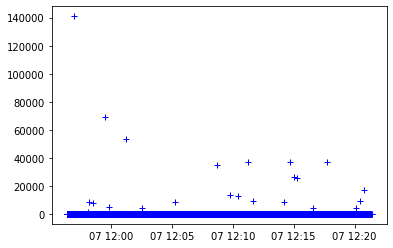

In [13]:
# Plot LOF
plt.plot(df["time"], df["lof"], 'b+')

Column acceleration_x
Column acceleration_y
Column acceleration_z
Column gyroscope_x
Column gyroscope_y
Column gyroscope_z
Column latitude
Column longitude
Column height
Column velocity
Column heart_rate
Num outliers: 0


Exception in Tkinter callback
Traceback (most recent call last):
  File "/home/alessandrobalducci/.conda/envs/myenv/lib/python3.8/tkinter/__init__.py", line 1892, in __call__
    return self.func(*args)
  File "/home/alessandrobalducci/.conda/envs/myenv/lib/python3.8/tkinter/__init__.py", line 814, in callit
    func(*args)
  File "/home/alessandrobalducci/.conda/envs/myenv/lib/python3.8/site-packages/matplotlib/backends/_backend_tk.py", line 270, in idle_draw
    self.draw()
  File "/home/alessandrobalducci/.conda/envs/myenv/lib/python3.8/site-packages/matplotlib/backends/backend_tkagg.py", line 9, in draw
    super(FigureCanvasTkAgg, self).draw()
  File "/home/alessandrobalducci/.conda/envs/myenv/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py", line 393, in draw
    self.figure.draw(self.renderer)
  File "/home/alessandrobalducci/.conda/envs/myenv/lib/python3.8/site-packages/matplotlib/backend_bases.py", line 1535, in _draw
    def _draw(renderer): raise Done(renderer

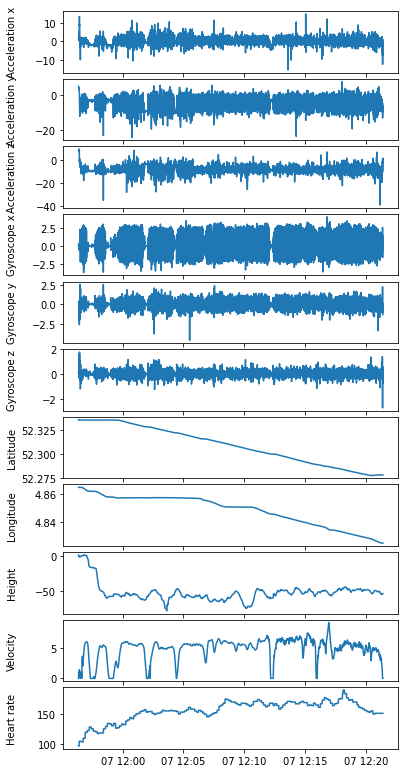

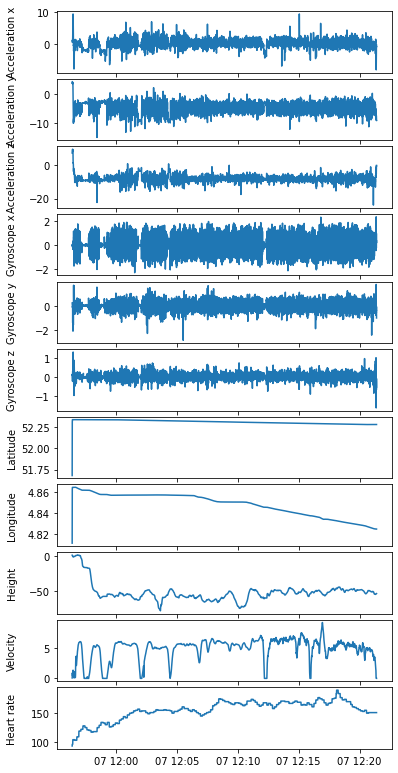

In [14]:
#The Kalman Filter
# used for detecting outliers and removing them in single step
# Running on all columns takes some time

import Python3Code.Chapter3.KalmanFilters as kf
from Python3Code.util.VisualizeDataset import VisualizeDataset

df = read_combined(target_dir2)

DataViz = VisualizeDataset()

KalFilter = kf.KalmanFilters()


#kalman_dataset.set_index("time", inplace=True)

#DataViz.plot_imputed_values(kalman_dataset, ['original', 'kalman'], col, kalman_dataset[col + '_kalman'])
#DataViz.plot_dataset(kalman_dataset, [col, col + '_kalman'], ['exact', 'exact'], ['line', 'line'])

df_orig = df.copy()
df_clean = df.copy()
n_outliers = 0

for col in cols:
    print(f"Column {col}")
    
    df_orig[col + "_outlier"] = False
    kalman_dataset = KalFilter.apply_kalman_filter(df_orig, col)
    #df_orig[col + "_outlier"] = np.where(df_orig[col] != kalman_dataset[col + "_kalman"], True, False)
    
    #n_outliers += len(df_orig.loc[df_orig[col + "_outlier"] == True])
    #print(n_outliers)
    
    df_clean[col] = kalman_dataset[col + "_kalman"]
    
print(f"Num outliers: {n_outliers}")
full_plot(df_orig, filename="kalman_original.pdf")
full_plot(df_clean, filename="kalman_clean.pdf")

In [ ]:
def find_stats(df, col):
    mean = df[col].mean()
    median = df[col].median()
    std = df[col].std()

    min = df[col].min()
    max = df[col].max()
    miss_per = round((df[col].isna().sum() / len(df[col])) * 100, 2)
    return mean, median, std, min, max, miss_per

def get_numerical_stats(df,cols):
    stats= {'Attributes':cols}
    res_df = pd.DataFrame(stats)
    mean_arr=[] 
    median_arr=[] 
    std_arr=[] 
    min_arr=[] 
    max_arr=[] 
    miss_per_arr =[] 
    for col in cols:
        mean, median, std, min, max, miss_per = find_stats(df, col)
        mean_arr.append(mean)
        median_arr.append(median)
        std_arr.append(std)
        min_arr.append(min)
        max_arr.append(max)
        miss_per_arr.append(miss_per)

    return res_df.assign(Missing = miss_per_arr,
                        Mean=mean_arr, StdDeviation=std_arr,
                        Min=min_arr,
                        Max=max_arr,
                        Median = median_arr )

cols = ["acceleration_x","acceleration_y","acceleration_z",	"gyroscope_x","gyroscope_y","gyroscope_z","latitude","longitude","height","velocity"]
res = (get_numerical_stats(df, cols))
print(res)
res.to_latex(buf=None, columns=None, header=True, index=True, na_rep='NaN', formatters=None, float_format=None, sparsify=None, index_names=True, bold_rows=False, column_format=None, longtable=None, escape=None, encoding=None, decimal='.', multicolumn=None, multicolumn_format=None, multirow=None, caption=None, label=None, position=None)